In [1]:
import pandas as pd
import numpy as np

# VaidyaCoders (Submission for VEERSA HACKATHON FOR 2026 BATCH)



##CHOSEN USE CASE: 4

## Problem Summary
Heart failure is a serious condition that can lead to death if not managed properly. Even after treatment and discharge, many patients are readmitted to the hospital within 30 days, which:
* Increases the risk of death (morbidity and mortality)
* Causes a financial burden for patients and families
* Puts more pressure on already overloaded healthcare systems.


## Our Objective

We need to develop a machine learning model to:
> **Predict whether a patient will be readmitted within 30 days of discharge after being treated for heart failure.**

This is a binary classification problem, where the target is:

1 (positive) → Patient is readmitted within 30 days.

0 (negative) → Patient is not readmitted within 30 days.

---


# **LOADING THE DATASETS**

A subset of 8 tables is shared with us (via OneDrive).
These tables are from MIMIC-III, a public ICU dataset.

We're expected to choose the relevant tables that will help us build a predictive model.

📚 Official MIMIC-III Table Documentation:

🔗 https://mimic.mit.edu/docs/iii/tables/

In [2]:
admissiondata = pd.read_csv('admissions_202208161605.csv')
admissiondata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                58976 non-null  int64 
 1   subject_id            58976 non-null  int64 
 2   hadm_id               58976 non-null  int64 
 3   admittime             58976 non-null  object
 4   dischtime             58976 non-null  object
 5   deathtime             5854 non-null   object
 6   admission_type        58976 non-null  object
 7   admission_location    58976 non-null  object
 8   discharge_location    58976 non-null  object
 9   insurance             58976 non-null  object
 10  language              33644 non-null  object
 11  religion              58518 non-null  object
 12  marital_status        48848 non-null  object
 13  ethnicity             58976 non-null  object
 14  edregtime             30877 non-null  object
 15  edouttime             30877 non-null

In [3]:
labitems = pd.read_csv('d_labitems_202208161605.csv')
labitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   row_id      753 non-null    int64 
 1   itemid      753 non-null    int64 
 2   label       753 non-null    object
 3   fluid       753 non-null    object
 4   category    753 non-null    object
 5   loinc_code  585 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.4+ KB


In [4]:
labevents = pd.read_csv('labevents_202208161605.csv')
labevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895282 entries, 0 to 3895281
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   row_id      int64  
 1   subject_id  int64  
 2   hadm_id     float64
 3   itemid      int64  
 4   charttime   object 
 5   value       object 
 6   valuenum    float64
 7   valueuom    object 
 8   flag        object 
dtypes: float64(2), int64(3), object(4)
memory usage: 267.5+ MB


In [5]:
diagnosisicd = pd.read_csv('diagnoses_icd_202208161605.csv')
diagnosisicd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   row_id      651047 non-null  int64  
 1   subject_id  651047 non-null  int64  
 2   hadm_id     651047 non-null  int64  
 3   seq_num     651000 non-null  float64
 4   icd9_code   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [6]:
patients = pd.read_csv('patients_202208161605.csv')
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       46520 non-null  int64 
 1   subject_id   46520 non-null  int64 
 2   gender       46520 non-null  object
 3   dob          46520 non-null  object
 4   dod          15759 non-null  object
 5   dod_hosp     9974 non-null   object
 6   dod_ssn      13378 non-null  object
 7   expire_flag  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB



#**MERGING REQ. TABLES & FEATURES TO CREATE ONE DATAFRAME.**
#(INCLUDES DATA CLEANING, PREPROCESSING WITH SOME NON-VISUAL EDA)

---

### Filter Heart Failure Patients

In [7]:
#ICD-9 stands for International Classification of Diseases, 9th Revision.
#It’s a standardized medical coding system used to represent diagnoses and diseases.

#Each ICD-9 code corresponds to a specific type or cause of heart failure.

#Important ICD-9 Codes (Heart Failure Identification)
#Using the following ICD-9 codes to identify heart failure patients in the diagnosis tables:


heart_failure_icd9 = [
    '39891','40201','40211','40291','40401','40403','40411','40413','40491','40493',
    '4280','4281','42820','42821','42822','42823','42830','42831','42832','42833',
    '42840','42841','42842','42843','4289'
]

In [8]:
print(diagnosisicd['icd9_code'].dtype) #ensuring they are not in float
print(diagnosisicd['icd9_code'].head(10))

object
0    40301
1      486
2    58281
3     5855
4     4254
5     2762
6     7100
7     2767
8     7243
9    45829
Name: icd9_code, dtype: object


In [9]:
hf_diag = diagnosisicd[diagnosisicd['icd9_code'].isin(heart_failure_icd9)]
# Filter the diagnosisicd DataFrame to keep only those rows where the
#'icd9_code' matches any of the heart failure ICD-9 codes.

<ipython-input-10-830d550c4cf5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='icd9_code', data=top_codes, palette='Reds_r')


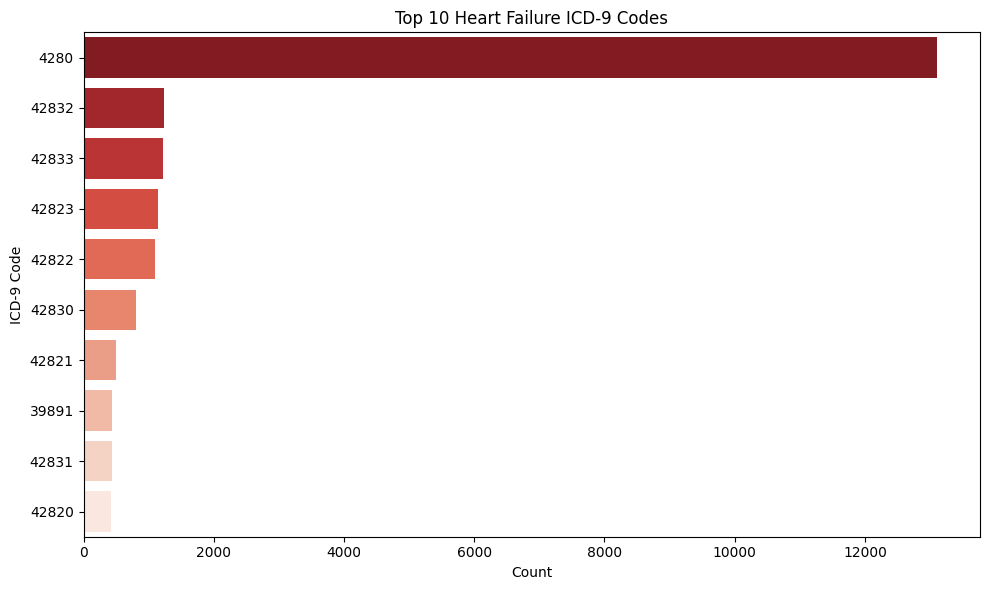

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count frequency of each ICD-9 code in the heart failure diagnosis dataframe
hf_code_counts = hf_diag['icd9_code'].value_counts().reset_index()
hf_code_counts.columns = ['icd9_code', 'count']

# sort values and take top 10
top_n = 10
top_codes = hf_code_counts.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='icd9_code', data=top_codes, palette='Reds_r')
plt.title(f"Top {top_n} Heart Failure ICD-9 Codes")
plt.xlabel("Count")
plt.ylabel("ICD-9 Code")
plt.tight_layout()
plt.show()

In [11]:
hf_admissions = hf_diag[['subject_id', 'hadm_id']].drop_duplicates() # get unique subject_id and hadm_id for heart failure admissions

print(f"Total heart failure admissions: {len(hf_admissions)}") # total number of heart failure admissions

Total heart failure admissions: 14040


---

### Merge with Admission Dataset

In [12]:
admissiondata.head(5)

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00.000,2196-04-10 15:54:00.000,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00.000,2196-04-09 13:24:00.000,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00.000,2153-09-08 19:10:00.000,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00.000,2157-10-25 14:00:00.000,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00.000,2139-06-09 12:48:00.000,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00.000,2160-11-05 14:55:00.000,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00.000,2160-11-02 04:27:00.000,ACUTE CORONARY SYNDROME,0,1


In [13]:
# merge heart failure admissions with admission data
hf_admissions_full = pd.merge(hf_admissions, admissiondata, on=['subject_id', 'hadm_id'], how='inner')

# changing in pandas datetime format (useful for timeseries analysis)
hf_admissions_full['admittime'] = pd.to_datetime(hf_admissions_full['admittime'])
hf_admissions_full['dischtime'] = pd.to_datetime(hf_admissions_full['dischtime'])


#sorting first by patient (subject_id), and within each patient, by the date/time of admission (admittime)
hf_admissions_full = hf_admissions_full.sort_values(by=['subject_id', 'admittime'])
hf_admissions_full.head()

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
9,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00.000,2101-10-20 19:24:00.000,HYPOTENSION,0,1
10,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,NaN,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00.000,2149-11-09 13:18:00.000,HEMORRHAGIC CVA,1,1
11,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,NaN,JEWISH,MARRIED,WHITE,2134-09-11 09:22:00.000,2134-09-11 22:30:00.000,CONGESTIVE HEART FAILURE,0,1
12,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
13,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1


In [14]:
hf_admissions_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14040 entries, 9 to 13993
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            14040 non-null  int64         
 1   hadm_id               14040 non-null  int64         
 2   row_id                14040 non-null  int64         
 3   admittime             14040 non-null  datetime64[ns]
 4   dischtime             14040 non-null  datetime64[ns]
 5   deathtime             2030 non-null   object        
 6   admission_type        14040 non-null  object        
 7   admission_location    14040 non-null  object        
 8   discharge_location    14040 non-null  object        
 9   insurance             14040 non-null  object        
 10  language              8817 non-null   object        
 11  religion              13959 non-null  object        
 12  marital_status        13564 non-null  object        
 13  ethnicity            

----

## **Identify 30-Day Readmissions**
### Patient Filtering Criteria

To accurately identify 30-day readmissions among heart failure patients, we begin by constructing a clean and reliable dataset that captures valid hospital admissions and their outcomes. Our objective is to label admissions where the patient was readmitted to the hospital within 30 days of discharge. However, to ensure this labeling is meaningful and accurate, we must apply specific filtering rules at the admission level.

In [15]:
#create a new column where each row knows when the next admission occurred.
hf_admissions_full['next_admittime'] = hf_admissions_full.groupby('subject_id')['admittime'].shift(-1) # get the next admission time for each subject

# get the current discharge time for each subject for calc
hf_admissions_full['current_dischtime'] = hf_admissions_full['dischtime']

In [16]:
# calculate the days to next admission
hf_admissions_full['days_to_next_admit'] = (hf_admissions_full['next_admittime'] - hf_admissions_full['current_dischtime']).dt.days

 # check if the next admission is within 30 days
hf_admissions_full['readmit_30_days'] = hf_admissions_full['days_to_next_admit'].apply(lambda x: 1 if pd.notnull(x) and x >= 0 and x <= 30 else 0)

In [17]:
# Shows proportion of patients readmitted within 30 days
hf_admissions_full['readmit_30_days'].value_counts(normalize=True)

,proportion
readmit_30_days,
0,0.931054
1,0.068946


<Axes: title={'center': 'Readmission within 30 days'}, xlabel='readmit_30_days'>

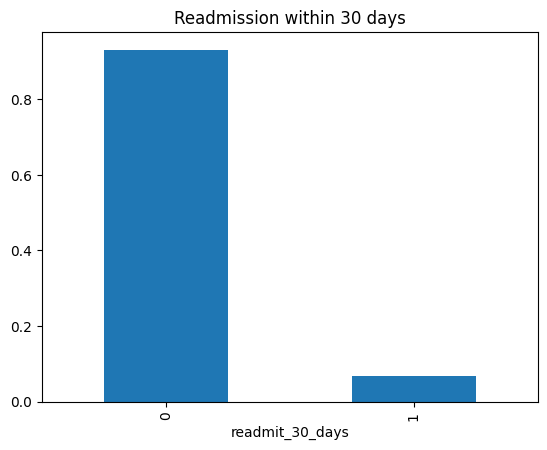

In [18]:
# plot the readmissions within 30 days
# to get a visual idea of how imbalanced the dataset might be
hf_admissions_full['readmit_30_days'].value_counts(normalize=True).plot(kind='bar', title='Readmission within 30 days')

The Dataset is clearly imbalanced.
## Demographics


In [19]:
patients['dob'] = pd.to_datetime(patients['dob'])
# merge the patient demographics with heart failure admissions
hf_admissions_full = hf_admissions_full.merge(patients[['subject_id', 'gender', 'dob']], on='subject_id', how='left')

In [20]:
hf_admissions_full.head(5)

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,next_admittime,current_dischtime,days_to_next_admit,readmit_30_days,gender,dob
0,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,2101-10-20 19:24:00.000,HYPOTENSION,0,1,NaT,2101-10-31 13:58:00,NaN,0,M,2025-04-11
1,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,2149-11-09 13:18:00.000,HEMORRHAGIC CVA,1,1,NaT,2149-11-14 10:15:00,NaN,0,M,2108-01-26
2,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,2134-09-11 22:30:00.000,CONGESTIVE HEART FAILURE,0,1,NaT,2134-09-24 16:15:00,NaN,0,M,2047-04-04
3,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,NaN,V-TACH,0,1,NaT,2126-05-13 15:00:00,NaN,0,M,2054-05-04
4,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,UNSTABLE ANGINA\CATH,0,1,NaT,2172-10-19 14:37:00,NaN,0,M,1872-10-14


In [21]:
print(hf_admissions_full.columns.tolist())

['subject_id', 'hadm_id', 'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'next_admittime', 'current_dischtime', 'days_to_next_admit', 'readmit_30_days', 'gender', 'dob']


## Adding Relevant features to the main dataframe

Figuring out the relevant features to use for model implentation.

 Most were chosen through research papers. Some efficient cleaning has also been done.

In [22]:
hf_admissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14040 entries, 51 to 651016
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   subject_id  14040 non-null  int64
 1   hadm_id     14040 non-null  int64
dtypes: int64(2)
memory usage: 329.1 KB


In [23]:
hf_admissions_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14040 entries, 0 to 14039
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            14040 non-null  int64         
 1   hadm_id               14040 non-null  int64         
 2   row_id                14040 non-null  int64         
 3   admittime             14040 non-null  datetime64[ns]
 4   dischtime             14040 non-null  datetime64[ns]
 5   deathtime             2030 non-null   object        
 6   admission_type        14040 non-null  object        
 7   admission_location    14040 non-null  object        
 8   discharge_location    14040 non-null  object        
 9   insurance             14040 non-null  object        
 10  language              8817 non-null   object        
 11  religion              13959 non-null  object        
 12  marital_status        13564 non-null  object        
 13  ethnicity       

In [24]:
# Calculate age in years using NumPy timedelta64 to avoid int overflow
hf_admissions_full['age'] = (hf_admissions_full['admittime'].values.astype('datetime64[Y]') -
                              hf_admissions_full['dob'].values.astype('datetime64[Y]')).astype(int)

In [25]:
hf_admissions_full['age'] = hf_admissions_full['age'].clip(lower=0, upper=90) # clip the age to 0-90 years

In [26]:
hf_admissions_full['age'].describe()

,age
count,14040.000000
mean,72.111325
std,13.680596
min,0.000000
25%,63.000000
50%,75.000000
75%,83.000000
max,90.000000


In [27]:
# Number of diagnosis per hospital admission and comorbidities
diagnosis_counts = diagnosisicd.groupby('hadm_id').size().reset_index(name='num_diagnoses')
hf_admissions_full = hf_admissions_full.merge(diagnosis_counts, on='hadm_id', how='left')

In [28]:
hf_admissions_full['num_diagnoses'].describe()

,num_diagnoses
count,14040.000000
mean,14.935114
std,6.694976
min,2.000000
25%,9.000000
50%,14.000000
75%,19.000000
max,39.000000


In [29]:
hf_admissions_full['num_diagnoses'] = hf_admissions_full['num_diagnoses'].fillna(0)

In [30]:
hf_hadm_ids = hf_admissions_full['hadm_id'].unique()
hf_diagnoses = diagnosisicd[diagnosisicd['hadm_id'].isin(hf_hadm_ids)]


In [31]:
top_icd9 = (
    hf_diagnoses['icd9_code']
    .value_counts()
    .head(10)
    .index
    .tolist()
)

print("Top 10 ICD-9 codes:", top_icd9)

# Create binary features for the top 10 ICD-9 codes
for code in top_icd9:
    hf_admissions_full[f'has_icd9_{code}'] = hf_admissions_full['hadm_id'].isin(
        hf_diagnoses[hf_diagnoses['icd9_code'] == code]['hadm_id']
    ).astype(int)

Top 10 ICD-9 codes: ['4280', '42731', '4019', '41401', '5849', '25000', '51881', '2724', '5990', '496']


In [32]:
hf_admissions_full.head(5)

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,has_icd9_4280,has_icd9_42731,has_icd9_4019,has_icd9_41401,has_icd9_5849,has_icd9_25000,has_icd9_51881,has_icd9_2724,has_icd9_5990,has_icd9_496
0,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,1,0,0,0,1,0,0,0,0,0
1,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,1,0,1,0,1,0,0,0,0,0
2,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,1,1,0,1,1,1,0,0,0,0
3,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,1,1,0,1,0,0,0,0,0,0
4,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0,0,1,1,0,0,0,0,0,0


In [33]:
labitems.head(5)

,row_id,itemid,label,fluid,category,loinc_code
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [34]:
labevents.head(5)

,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,281,3,NaN,50820,2101-10-12 16:07:00.000,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00.000,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00.000,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00.000,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00.000,0.93,0.93,mmol/L,abnormal


In [35]:
labitems['fluid'].dropna().unique()

array(['Cerebrospinal Fluid (CSF)', 'Joint Fluid', 'Other Body Fluid',
       'Pleural', 'Stool', 'Urine', 'BLOOD', 'Blood', 'Ascites',
       'Bone Marrow', 'OTHER BODY FLUID', 'URINE', 'JOINT FLUID', 'CSF',
       'ASCITES', 'STOOL'], dtype=object)

In [36]:
labitems['fluid'] = labitems['fluid'].str.upper().fillna('')

# Select only blood/serum/plasma fluids
valid_fluids = ['BLOOD', 'SERUM', 'PLASMA']
d_labitems_blood = labitems[labitems['fluid'].isin(valid_fluids)]

In [37]:
key_labs = ['GLUCOSE', 'CREATININE', 'BUN', 'SODIUM', 'POTASSIUM', 'CHLORIDE',
            'HEMOGLOBIN', 'HEMATOCRIT', 'PLATELET COUNT', 'WHITE BLOOD CELL COUNT']

# Only keep matching labels and valid fluids
selected_labs = d_labitems_blood[d_labitems_blood['label'].str.upper().isin(key_labs)]

In [38]:
lab_itemids = set(selected_labs['itemid'].values)

# Filter labevents for those itemids only
lab_filtered = labevents[labevents['itemid'].isin(lab_itemids)]

In [39]:
lab_filtered = lab_filtered.dropna(subset=['hadm_id', 'valuenum'])

# Get first lab value per hadm_id per itemid
lab_first = lab_filtered.sort_values('charttime').groupby(['hadm_id', 'itemid']).first().reset_index()

# Pivot to wide format
lab_pivot = lab_first.pivot(index='hadm_id', columns='itemid', values='valuenum')

# Rename columns to lab names
id_to_label = dict(zip(selected_labs['itemid'], selected_labs['label'].str.lower().str.replace(" ", "_")))
lab_pivot.rename(columns=id_to_label, inplace=True)

# Merge into main table
hf_admissions_full = hf_admissions_full.merge(lab_pivot, on='hadm_id', how='left')

In [40]:
hf_admissions_full.head(5)

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,glucose,hemoglobin,chloride,creatinine,glucose,potassium,sodium,hematocrit,hemoglobin,platelet_count
0,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,140.0,10.3,99.0,3.2,91.0,5.4,136.0,30.2,10.0,282.0
1,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,178.0,14.0,100.0,1.2,129.0,2.8,140.0,45.2,15.4,258.0
2,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,128.0,9.2,105.0,3.2,190.0,5.1,138.0,32.0,9.7,310.0
3,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,NaN,NaN,108.0,1.2,106.0,4.5,143.0,38.0,12.2,168.0
4,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,9.5,97.0,2.1,217.0,4.1,129.0,27.6,9.5,211.0


In [41]:
print(hf_admissions_full.columns.tolist())

['subject_id', 'hadm_id', 'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'next_admittime', 'current_dischtime', 'days_to_next_admit', 'readmit_30_days', 'gender', 'dob', 'age', 'num_diagnoses', 'has_icd9_4280', 'has_icd9_42731', 'has_icd9_4019', 'has_icd9_41401', 'has_icd9_5849', 'has_icd9_25000', 'has_icd9_51881', 'has_icd9_2724', 'has_icd9_5990', 'has_icd9_496', 'glucose', 'hemoglobin', 'chloride', 'creatinine', 'glucose', 'potassium', 'sodium', 'hematocrit', 'hemoglobin', 'platelet_count']


In [42]:
glucose_items = labitems[labitems['label'].str.contains('glucose', case=False)]
print(glucose_items[['itemid', 'label', 'fluid', 'category']])

     itemid                     label                      fluid    category
136   50809                   Glucose                      BLOOD   Blood Gas
169   50842          Glucose, Ascites                    ASCITES   Chemistry
259   50931                   Glucose                      BLOOD   Chemistry
342   51014              Glucose, CSF  CEREBROSPINAL FLUID (CSF)   Chemistry
350   51022      Glucose, Joint Fluid                JOINT FLUID   Chemistry
362   51034       Glucose, Body Fluid           OTHER BODY FLUID   Chemistry
381   51053          Glucose, Pleural                    PLEURAL   Chemistry
412   51084            Glucose, Urine                      URINE   Chemistry
677   51478                   Glucose                      URINE  Hematology
728   51529  Estimated Actual Glucose                      BLOOD   CHEMISTRY


In [43]:
#too many glucose labels
lab_events_merged = labevents.merge(
    labitems[['itemid', 'label', 'fluid', 'category']],
    on='itemid',
    how='left'
)

In [44]:
lab_events_merged['label_unique'] = (
    lab_events_merged['label'].str.replace('[^A-Za-z0-9]+', '_', regex=True) +
    '_' + lab_events_merged['fluid'].str.replace('[^A-Za-z0-9]+', '_', regex=True)
)

In [45]:
lab_pivot = lab_events_merged.pivot_table(
    index='hadm_id',
    columns='label_unique',
    values='valuenum',
    aggfunc='mean'
).reset_index()

In [46]:
hf_admissions_full = hf_admissions_full.drop(
    columns=[col for col in hf_admissions_full.columns if col in lab_pivot.columns and col != 'hadm_id'],
    errors='ignore'
)

hf_admissions_full = hf_admissions_full.merge(lab_pivot, on='hadm_id', how='left')

In [47]:
hf_admissions_full.head(5)

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,_Albumin__CEREBROSPINAL_FLUID_CSF_,_Hemoglobin_A1c_BLOOD,pCO2_BLOOD,pCO2_Body_Fluid_OTHER_BODY_FLUID,pH_BLOOD,pH_OTHER_BODY_FLUID,pH_URINE,pO2_BLOOD,pO2_Body_Fluid_OTHER_BODY_FLUID,tacroFK_BLOOD
0,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,NaN,NaN,30.368421,NaN,7.381538,NaN,5.000000,105.894737,NaN,NaN
1,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,NaN,5.6,37.714286,NaN,7.417857,NaN,6.500000,119.500000,NaN,NaN
2,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,NaN,NaN,44.090909,NaN,7.307143,NaN,5.833333,106.090909,NaN,NaN
3,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN
4,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,6.6,29.000000,NaN,7.330000,NaN,5.500000,90.000000,NaN,NaN


In [48]:
print(hf_admissions_full.columns.tolist())

['subject_id', 'hadm_id', 'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'next_admittime', 'current_dischtime', 'days_to_next_admit', 'readmit_30_days', 'gender', 'dob', 'age', 'num_diagnoses', 'has_icd9_4280', 'has_icd9_42731', 'has_icd9_4019', 'has_icd9_41401', 'has_icd9_5849', 'has_icd9_25000', 'has_icd9_51881', 'has_icd9_2724', 'has_icd9_5990', 'has_icd9_496', 'glucose', 'hemoglobin', 'chloride', 'creatinine', 'glucose', 'potassium', 'sodium', 'hematocrit', 'hemoglobin', 'platelet_count', '24_hr_Creatinine_URINE', '24_hr_Protein_URINE', 'Absolute_CD3_Count_BLOOD', 'Absolute_CD4_Count_BLOOD', 'Absolute_CD8_Count_BLOOD', 'Absolute_Lymphocyte_Count_BLOOD', 'Acetaminophen_BLOOD', 'Acetone_BLOOD', 'Alanine_Aminotransferase_ALT__BLOOD', 'Albumin_Ascites_ASCITES', 'Albumin_

In [49]:
#removing mostly-empty columns
columns_before_lab_merge = hf_admissions_full.columns[:37].tolist()
lab_cols = [col for col in hf_admissions_full.columns if col not in columns_before_lab_merge]
missing_ratio = hf_admissions_full[lab_cols].isna().mean().sort_values(ascending=False)
high_missing_cols = missing_ratio[missing_ratio > 0.95].index.tolist()

hf_admissions_full.drop(columns=high_missing_cols, inplace=True)

In [50]:
lab_cols = [col for col in lab_cols if col not in high_missing_cols]
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
hf_admissions_full[lab_cols] = imputer.fit_transform(hf_admissions_full[lab_cols])

In [51]:
hf_admissions_full.head(5)

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,Specific_Gravity_URINE,Temperature_BLOOD,Troponin_T_BLOOD,Urea_Nitrogen_BLOOD,WBC_URINE,White_Blood_Cells_BLOOD,pCO2_BLOOD,pH_BLOOD,pH_URINE,pO2_BLOOD
0,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,1.019800,37.161538,0.108,28.133333,35.0,12.533333,30.368421,7.381538,5.000000,105.894737
1,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,1.022000,36.354545,0.010,22.714286,0.0,13.500000,37.714286,7.417857,6.500000,119.500000
2,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,1.021333,36.644444,2.120,70.650000,30.0,18.011765,44.090909,7.307143,5.833333,106.090909
3,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,1.015000,37.050000,0.108,31.500000,0.0,7.283333,41.563492,7.385000,5.000000,113.450000
4,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1.028000,37.050000,0.108,56.000000,717.0,12.475000,29.000000,7.330000,5.500000,90.000000


In [52]:
print(hf_admissions_full.columns.tolist())

['subject_id', 'hadm_id', 'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'next_admittime', 'current_dischtime', 'days_to_next_admit', 'readmit_30_days', 'gender', 'dob', 'age', 'num_diagnoses', 'has_icd9_4280', 'has_icd9_42731', 'has_icd9_4019', 'has_icd9_41401', 'has_icd9_5849', 'has_icd9_25000', 'has_icd9_51881', 'has_icd9_2724', 'has_icd9_5990', 'has_icd9_496', 'glucose', 'hemoglobin', 'chloride', 'creatinine', 'glucose', 'potassium', 'sodium', 'hematocrit', 'hemoglobin', 'platelet_count', 'Alanine_Aminotransferase_ALT__BLOOD', 'Albumin_BLOOD', 'Alkaline_Phosphatase_BLOOD', 'Amylase_BLOOD', 'Anion_Gap_BLOOD', 'Asparate_Aminotransferase_AST__BLOOD', 'Bands_BLOOD', 'Base_Excess_BLOOD', 'Basophils_BLOOD', 'Bicarbonate_BLOOD', 'Bilirubin_Total_BLOOD', 'Calcium_Total_BLOOD

In [53]:
columns_to_drop = [col for col in hf_admissions_full.columns
                   if 'glucose' in col.lower() and 'blood' not in col.lower()]
columns_to_drop += [col for col in hf_admissions_full.columns
                    if 'hemoglobin' in col.lower() and 'blood' not in col.lower()]
print("Dropping columns:", columns_to_drop)

Dropping columns: ['glucose', 'glucose', 'hemoglobin', 'hemoglobin']


In [54]:
hf_admissions_full.drop(columns=columns_to_drop, inplace=True)

In [55]:
print(hf_admissions_full.columns.tolist())

['subject_id', 'hadm_id', 'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'next_admittime', 'current_dischtime', 'days_to_next_admit', 'readmit_30_days', 'gender', 'dob', 'age', 'num_diagnoses', 'has_icd9_4280', 'has_icd9_42731', 'has_icd9_4019', 'has_icd9_41401', 'has_icd9_5849', 'has_icd9_25000', 'has_icd9_51881', 'has_icd9_2724', 'has_icd9_5990', 'has_icd9_496', 'chloride', 'creatinine', 'potassium', 'sodium', 'hematocrit', 'platelet_count', 'Alanine_Aminotransferase_ALT__BLOOD', 'Albumin_BLOOD', 'Alkaline_Phosphatase_BLOOD', 'Amylase_BLOOD', 'Anion_Gap_BLOOD', 'Asparate_Aminotransferase_AST__BLOOD', 'Bands_BLOOD', 'Base_Excess_BLOOD', 'Basophils_BLOOD', 'Bicarbonate_BLOOD', 'Bilirubin_Total_BLOOD', 'Calcium_Total_BLOOD', 'Calculated_Total_CO2_BLOOD', 'Chloride_BLOOD',

In [56]:
low_yield_cols = [
    'Alveolar_arterial_Gradient_BLOOD',
    'Base_Excess_BLOOD',
    'Bands_BLOOD',
    'Basophils_BLOOD',
    'Bilirubin_Indirect_BLOOD',
    'Calculated_Bicarbonate_Whole_Blood_BLOOD',
    'Calculated_Total_CO2_BLOOD',
    'Cholesterol_HDL_BLOOD',
    'Cholesterol_LDL_Calculated_BLOOD',
    'Cholesterol_Ratio_Total_HDL__BLOOD',
    'Cholesterol_Total_BLOOD',
    'Creatine_Kinase_CK__BLOOD',
    'Creatine_Kinase_MB_Isoenzyme_BLOOD',
    'Eosinophils_BLOOD',
    'Ferritin_BLOOD',
    'Folate_BLOOD',
    'Free_Calcium_BLOOD',
    'Haptoglobin_BLOOD',
    'Iron_BLOOD',
    'Iron_Binding_Capacity_Total_BLOOD',
    'Lipase_BLOOD',
    'Magnesium_BLOOD',
    'Metamyelocytes_BLOOD',
    'Monocytes_BLOOD',
    'Myelocytes_BLOOD',
    'O2_Flow_BLOOD',
    'Oxygen_BLOOD',
    'Oxygen_Saturation_BLOOD',
    'PEEP_BLOOD',
    'Platelet_Count_BLOOD',
    'Potassium_Whole_Blood_BLOOD',
    'Protein_Total_BLOOD',
    'Reticulocyte_Count_Automated_BLOOD',
    'Required_O2_BLOOD',
    'Sedimentation_Rate_BLOOD',
    'Sodium_Whole_Blood_BLOOD',
    'Temperature_BLOOD',
    'Tidal_Volume_BLOOD',
    'Transferrin_BLOOD',
    'Triglycerides_BLOOD',
    'Uric_Acid_BLOOD',
    'Urobilinogen_URINE',
    'Vancomycin_BLOOD',
    'Vitamin_B12_BLOOD',
    'WBC_URINE', 'RBC_URINE', 'Protein_URINE',
    'Osmolality_Urine_URINE', 'Sodium_Urine_URINE', 'Potassium_Urine_URINE',
    'Chloride_Urine_URINE', 'Creatinine_Urine_URINE', 'Urea_Nitrogen_Urine_URINE',
    'Protein_Creatinine_Ratio_URINE', 'Total_Protein_Urine_URINE',
    'Epithelial_Cells_URINE', 'Hyaline_Casts_URINE', 'Specific_Gravity_URINE',
    'Ketone_URINE', 'pH_URINE',
]

hf_admissions_full.drop(columns=[col for col in low_yield_cols if col in hf_admissions_full.columns], inplace=True)

In [57]:
hf_admissions_full.head(5)

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,Potassium_BLOOD,RDW_BLOOD,Red_Blood_Cells_BLOOD,Sodium_BLOOD,Troponin_T_BLOOD,Urea_Nitrogen_BLOOD,White_Blood_Cells_BLOOD,pCO2_BLOOD,pH_BLOOD,pO2_BLOOD
0,3,145834,2,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,4.105263,15.786667,3.339333,137.555556,0.108,28.133333,12.533333,30.368421,7.381538,105.894737
1,9,150750,8,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,3.310000,14.150000,4.503750,134.300000,0.010,22.714286,13.500000,37.714286,7.417857,119.500000
2,21,109451,19,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,4.160870,17.788235,3.580588,138.300000,2.120,70.650000,18.011765,44.090909,7.307143,106.090909
3,26,197661,26,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,4.155556,13.450000,3.636667,137.625000,0.108,31.500000,7.283333,41.563492,7.385000,113.450000
4,30,104557,29,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,4.025000,13.200000,3.160000,132.000000,0.108,56.000000,12.475000,29.000000,7.330000,90.000000


## The final Dataset after Merging

In [58]:
# FINAL DATASET AFTER MERGING
hf_admissions_full.shape

(14040, 79)

# **EXPLORATORY DATA ANALYSIS**

In [59]:
hf_admissions_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14040 entries, 0 to 14039
Data columns (total 79 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   subject_id                            14040 non-null  int64         
 1   hadm_id                               14040 non-null  int64         
 2   row_id                                14040 non-null  int64         
 3   admittime                             14040 non-null  datetime64[ns]
 4   dischtime                             14040 non-null  datetime64[ns]
 5   deathtime                             2030 non-null   object        
 6   admission_type                        14040 non-null  object        
 7   admission_location                    14040 non-null  object        
 8   discharge_location                    14040 non-null  object        
 9   insurance                             14040 non-null  object        
 10

In [60]:
hf_admissions_full.describe(include='all')  # Include categorical and numerical

,subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,Potassium_BLOOD,RDW_BLOOD,Red_Blood_Cells_BLOOD,Sodium_BLOOD,Troponin_T_BLOOD,Urea_Nitrogen_BLOOD,White_Blood_Cells_BLOOD,pCO2_BLOOD,pH_BLOOD,pO2_BLOOD
count,14040.000000,14040.000000,14040.000000,14040,14040,2030,14040,14040,14040,14040,...,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000
unique,NaN,NaN,NaN,NaN,NaN,2029,4,8,16,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,2108-02-22 15:15:00.000,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,2,12143,6460,3516,10568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,32674.302208,150176.220442,28827.253134,2151-06-06 23:11:30.726495232,2151-06-18 09:15:41.722221568,NaN,NaN,NaN,NaN,NaN,...,4.162781,15.506571,3.484729,138.990450,0.148987,29.161085,10.215513,41.787709,7.384203,114.906178
min,3.000000,100018.000000,2.000000,2100-06-28 19:29:00,2100-07-07 18:05:00,NaN,NaN,NaN,NaN,NaN,...,3.200000,11.528571,1.080000,120.750000,0.010000,2.500000,0.390000,19.652174,6.891250,14.000000
25%,11701.000000,124845.000000,14332.000000,2126-06-06 16:54:44.999999488,2126-06-14 03:41:15.000000512,NaN,NaN,NaN,NaN,NaN,...,4.155556,15.459341,3.475268,139.000000,0.108000,28.375000,10.050000,41.563492,7.385000,113.450000
50%,23123.000000,150302.000000,28215.000000,2151-02-06 17:32:00,2151-02-24 14:30:00,NaN,NaN,NaN,NaN,NaN,...,4.155556,15.459341,3.475268,139.000000,0.108000,28.375000,10.050000,41.563492,7.385000,113.450000
75%,51470.000000,175380.250000,43424.500000,2176-07-16 22:03:00,2176-07-27 14:52:30,NaN,NaN,NaN,NaN,NaN,...,4.155556,15.459341,3.475268,139.000000,0.108000,28.375000,10.050000,41.563492,7.385000,113.450000
max,99995.000000,199994.000000,58975.000000,2209-07-14 21:35:00,2209-07-15 17:20:00,NaN,NaN,NaN,NaN,NaN,...,7.271429,27.900000,5.658571,155.692308,20.950000,158.166667,467.666667,135.500000,7.695000,524.000000


In [61]:
missing = hf_admissions_full.isnull().sum()
missing_percent = (missing / len(hf_admissions_full)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
missing_summary

,Missing Count,Missing %
deathtime,12010,85.541311
next_admittime,10436,74.330484
days_to_next_admit,10436,74.330484
edregtime,5453,38.839031
edouttime,5453,38.839031
language,5223,37.200855
marital_status,476,3.390313
religion,81,0.576923
diagnosis,3,0.021368


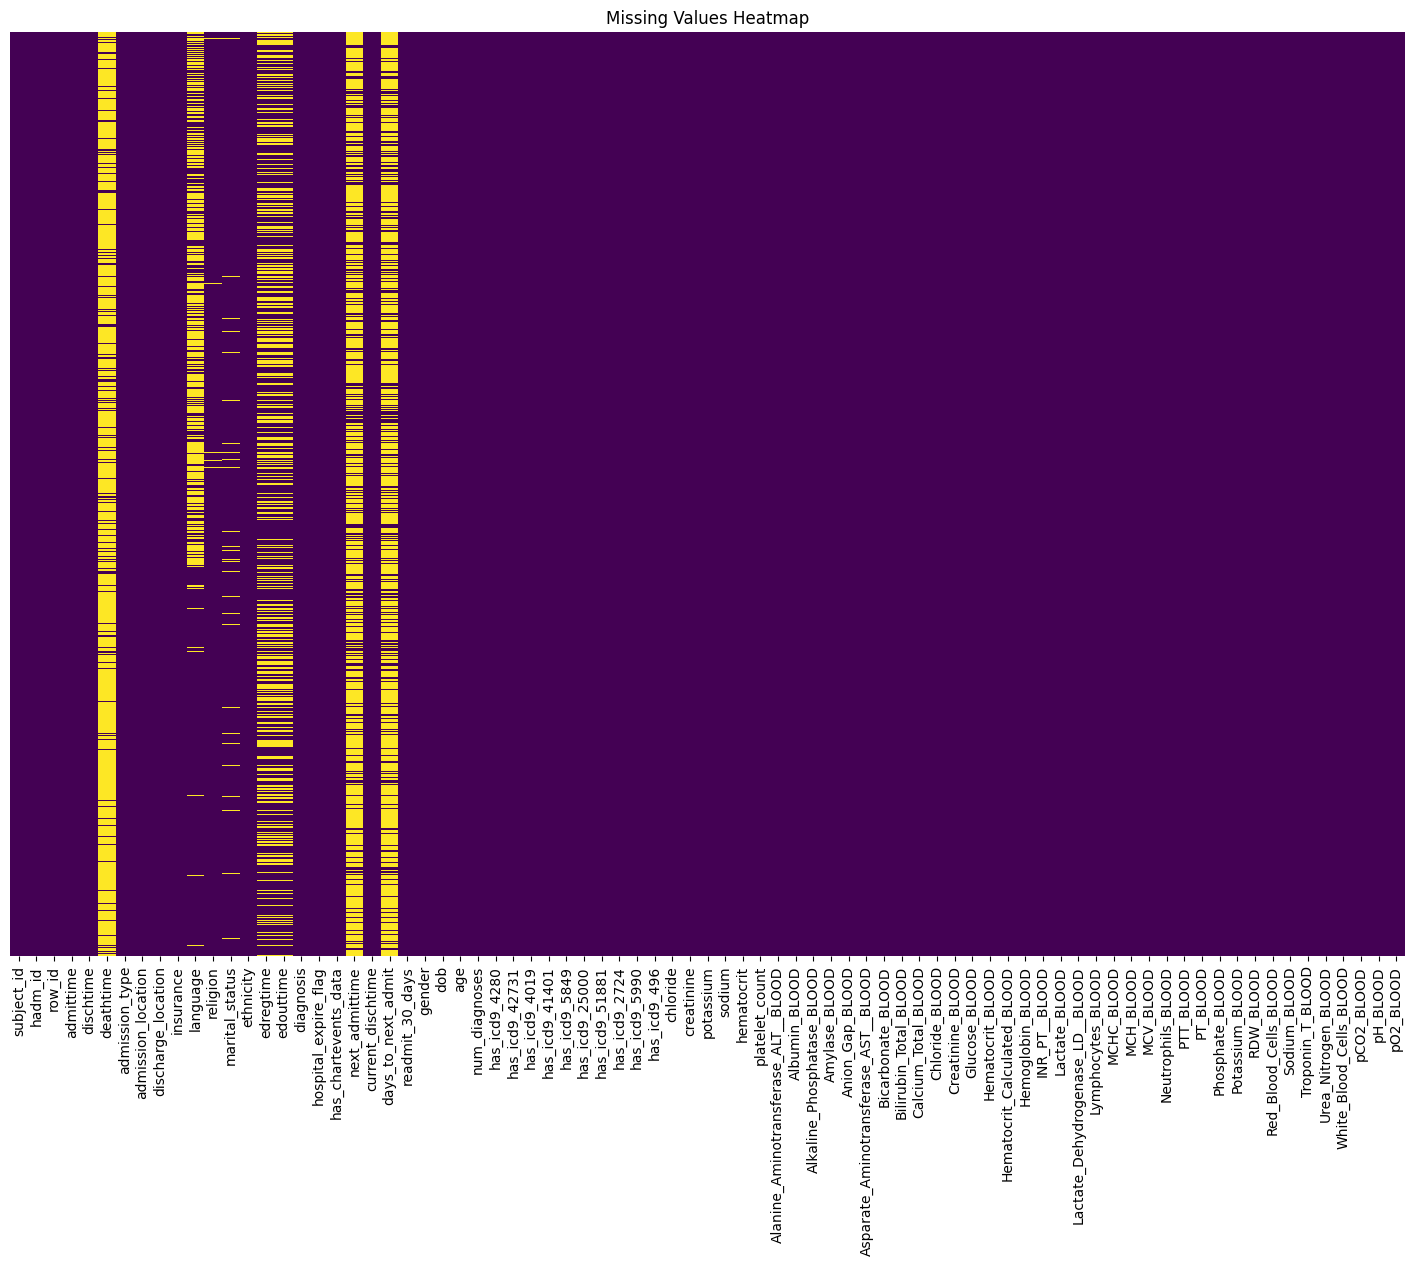

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 12))
sns.heatmap(hf_admissions_full.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [63]:
cols_to_drop = ['deathtime', 'next_admittime', 'days_to_next_admit', 'language']
hf_admissions_full.drop(columns=cols_to_drop, inplace=True)

In [64]:
hf_admissions_full.drop(columns=['edregtime', 'edouttime'], inplace=True)

In [65]:
hf_admissions_full['marital_status'].fillna(hf_admissions_full['marital_status'].mode()[0], inplace=True)
hf_admissions_full['religion'].fillna(hf_admissions_full['religion'].mode()[0], inplace=True)
hf_admissions_full['diagnosis'].fillna(hf_admissions_full['diagnosis'].mode()[0], inplace=True)

<ipython-input-65-9fe14054d2c0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hf_admissions_full['marital_status'].fillna(hf_admissions_full['marital_status'].mode()[0], inplace=True)
<ipython-input-65-9fe14054d2c0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [66]:
hf_admissions_full.isnull().sum().sum()

np.int64(0)

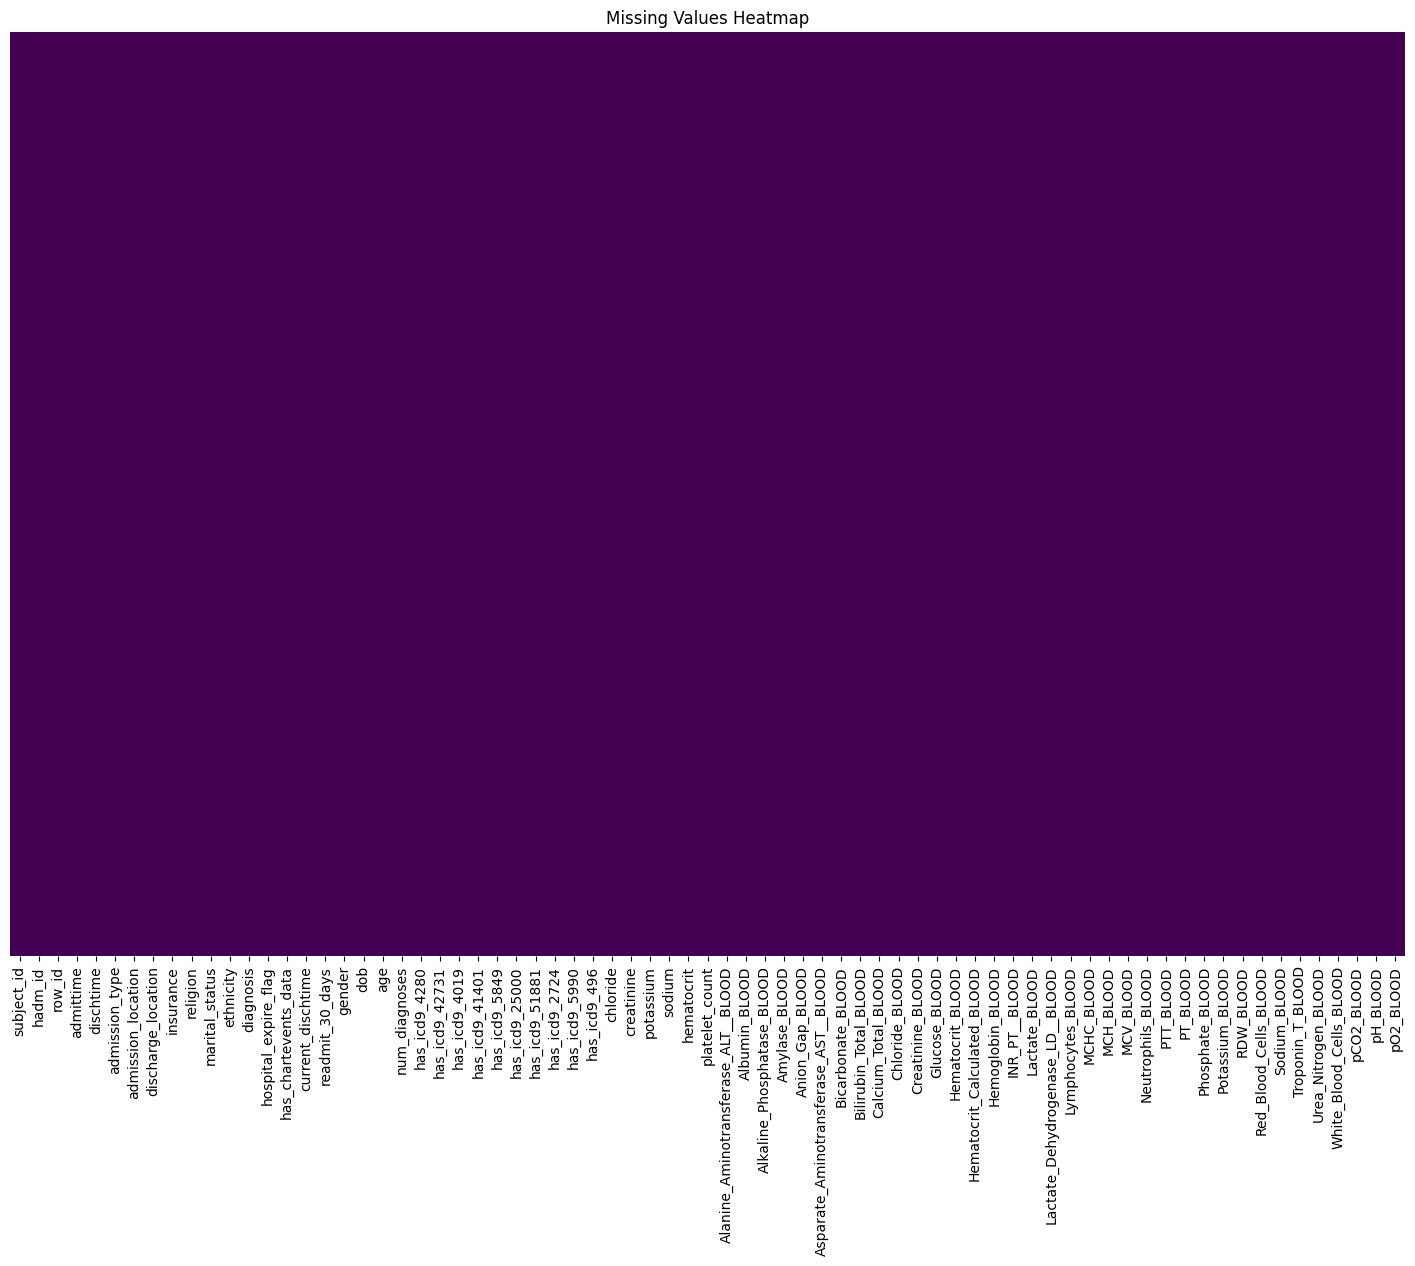

In [67]:
plt.figure(figsize=(18, 12))
sns.heatmap(hf_admissions_full.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [68]:
numerical_cols = hf_admissions_full.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
categorical_cols = hf_admissions_full.select_dtypes(include=['object', 'category']).columns.tolist()

In [69]:
# Column types
numeric_cols = hf_admissions_full.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
categorical_cols = hf_admissions_full.select_dtypes(include='object').columns.tolist()
datetime_cols = hf_admissions_full.select_dtypes(include='datetime64').columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("Datetime columns:", datetime_cols)

Numeric columns: ['subject_id', 'hadm_id', 'row_id', 'hospital_expire_flag', 'has_chartevents_data', 'readmit_30_days', 'age', 'num_diagnoses', 'has_icd9_4280', 'has_icd9_42731', 'has_icd9_4019', 'has_icd9_41401', 'has_icd9_5849', 'has_icd9_25000', 'has_icd9_51881', 'has_icd9_2724', 'has_icd9_5990', 'has_icd9_496', 'chloride', 'creatinine', 'potassium', 'sodium', 'hematocrit', 'platelet_count', 'Alanine_Aminotransferase_ALT__BLOOD', 'Albumin_BLOOD', 'Alkaline_Phosphatase_BLOOD', 'Amylase_BLOOD', 'Anion_Gap_BLOOD', 'Asparate_Aminotransferase_AST__BLOOD', 'Bicarbonate_BLOOD', 'Bilirubin_Total_BLOOD', 'Calcium_Total_BLOOD', 'Chloride_BLOOD', 'Creatinine_BLOOD', 'Glucose_BLOOD', 'Hematocrit_BLOOD', 'Hematocrit_Calculated_BLOOD', 'Hemoglobin_BLOOD', 'INR_PT__BLOOD', 'Lactate_BLOOD', 'Lactate_Dehydrogenase_LD__BLOOD', 'Lymphocytes_BLOOD', 'MCHC_BLOOD', 'MCH_BLOOD', 'MCV_BLOOD', 'Neutrophils_BLOOD', 'PTT_BLOOD', 'PT_BLOOD', 'Phosphate_BLOOD', 'Potassium_BLOOD', 'RDW_BLOOD', 'Red_Blood_Cells_B

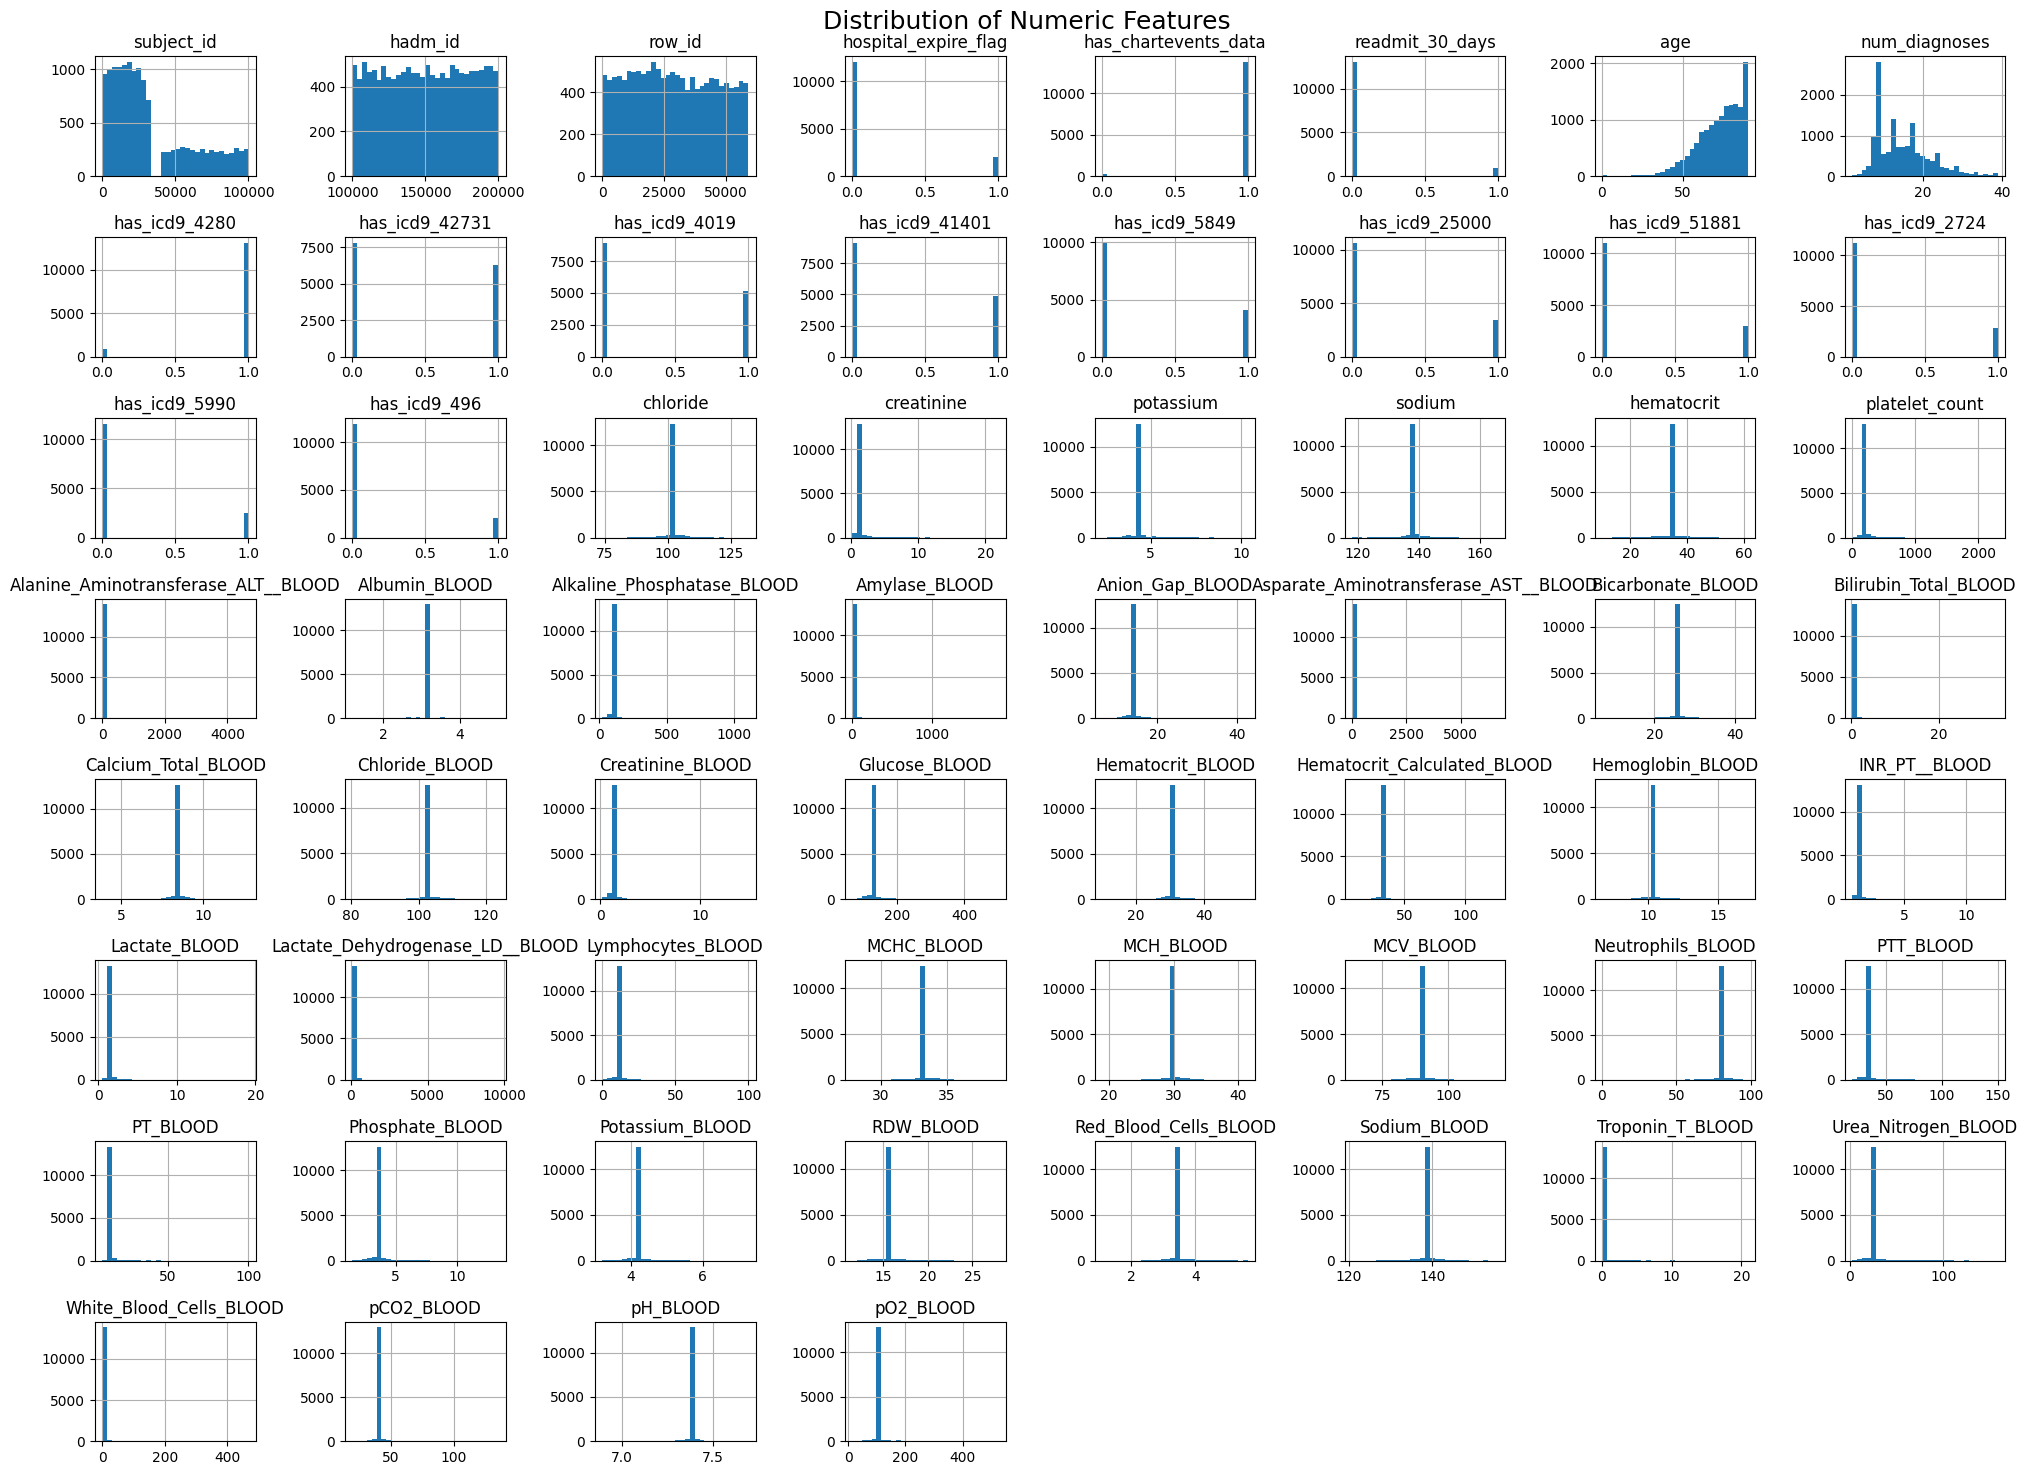

In [70]:
hf_admissions_full[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.suptitle("Distribution of Numeric Features", fontsize=18)
plt.tight_layout()
plt.show()


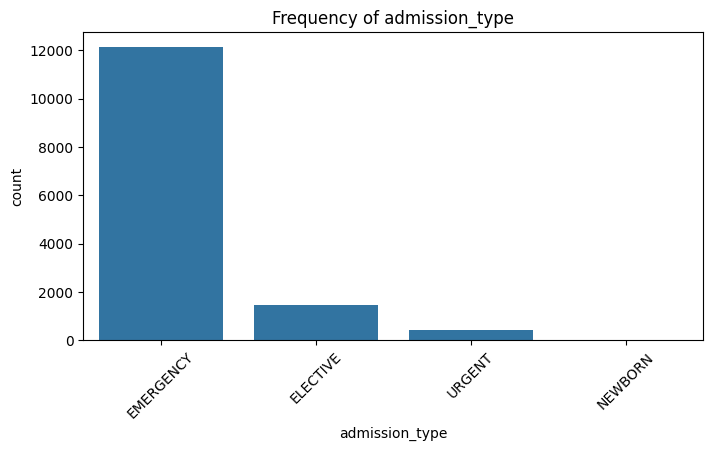

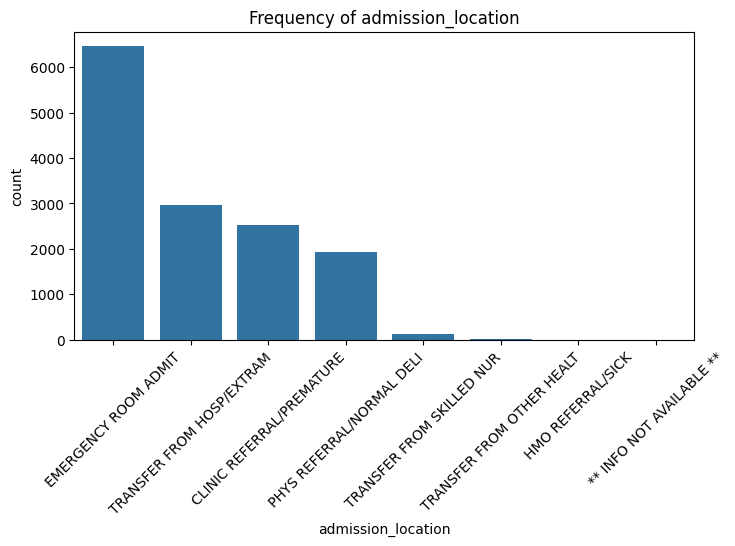

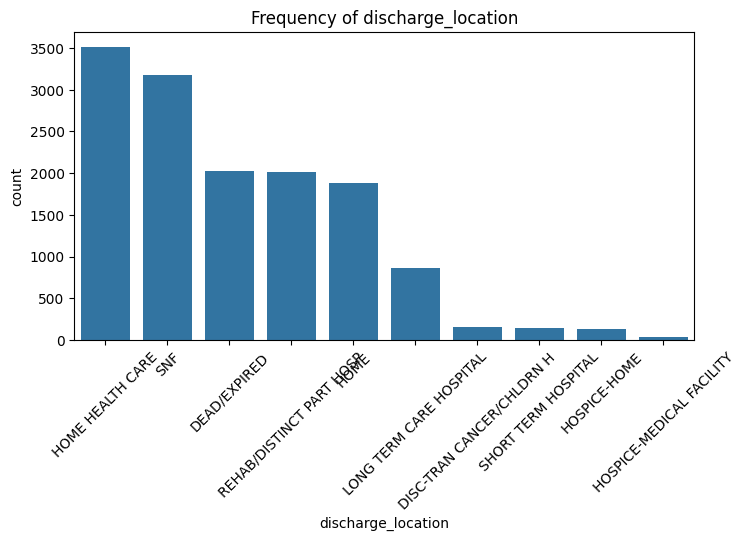

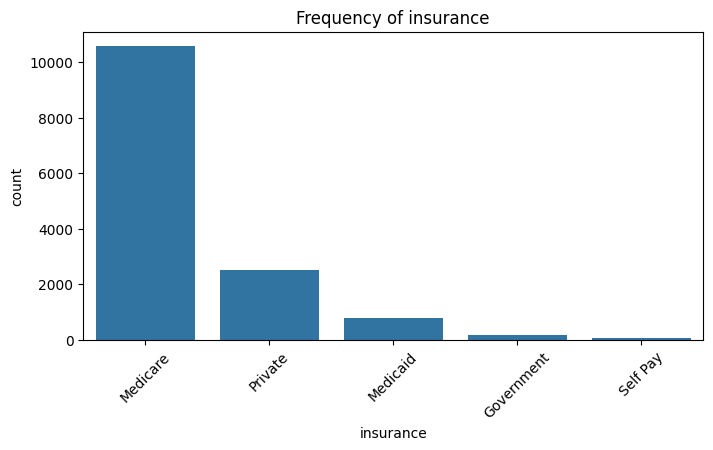

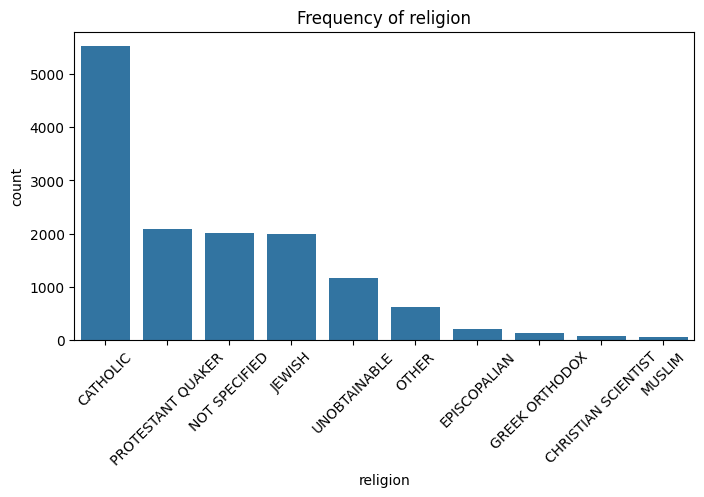

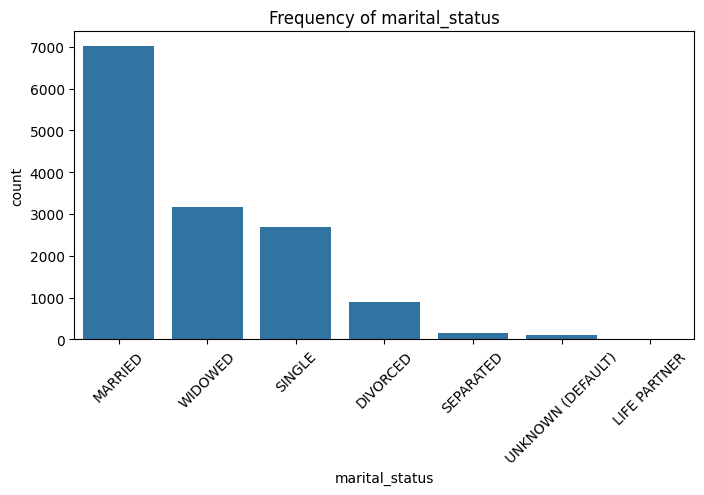

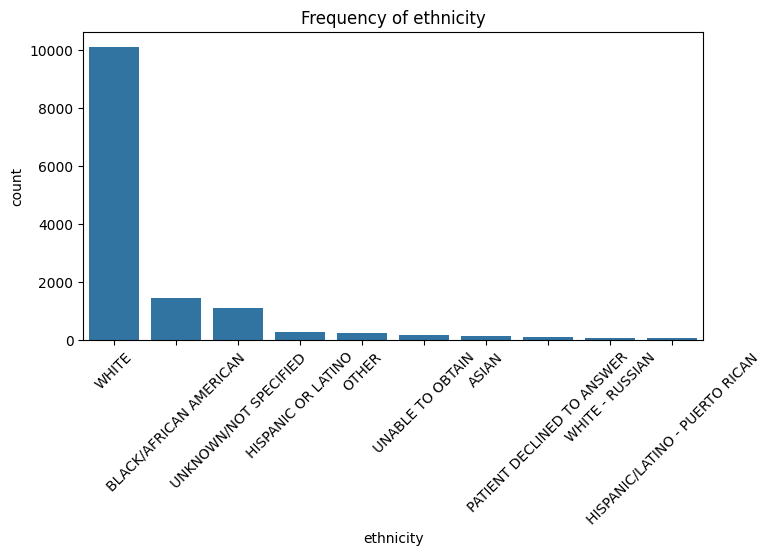

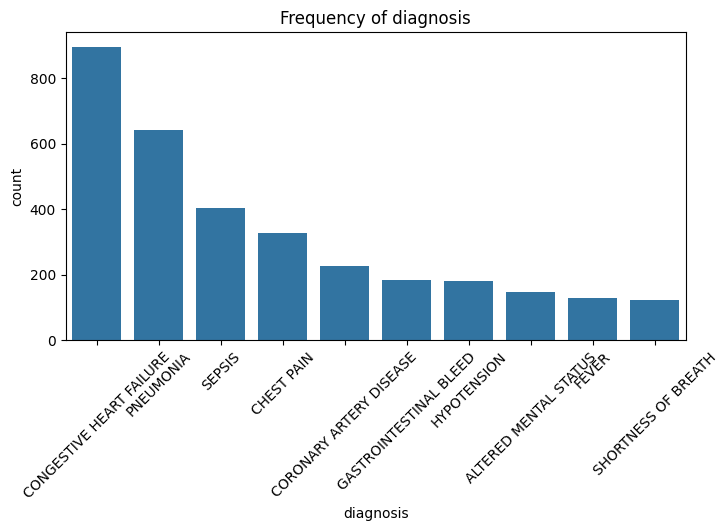

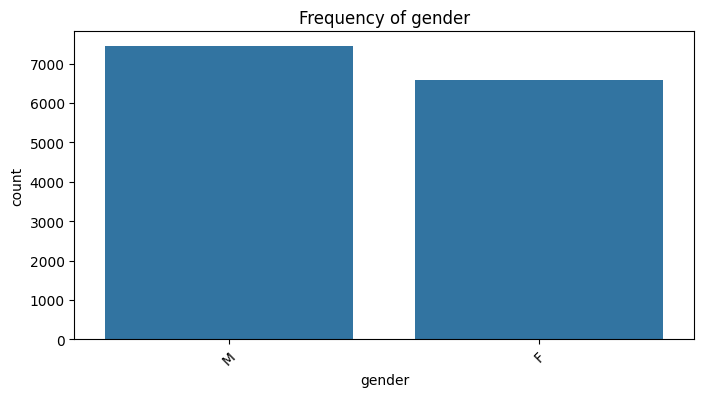

In [71]:
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=hf_admissions_full, x=col, order=hf_admissions_full[col].value_counts().index[:10])
    plt.title(f"Frequency of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [72]:
hf_admissions_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14040 entries, 0 to 14039
Data columns (total 73 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   subject_id                            14040 non-null  int64         
 1   hadm_id                               14040 non-null  int64         
 2   row_id                                14040 non-null  int64         
 3   admittime                             14040 non-null  datetime64[ns]
 4   dischtime                             14040 non-null  datetime64[ns]
 5   admission_type                        14040 non-null  object        
 6   admission_location                    14040 non-null  object        
 7   discharge_location                    14040 non-null  object        
 8   insurance                             14040 non-null  object        
 9   religion                              14040 non-null  object        
 10

In [73]:
hf_admissions_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14040 entries, 0 to 14039
Data columns (total 73 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   subject_id                            14040 non-null  int64         
 1   hadm_id                               14040 non-null  int64         
 2   row_id                                14040 non-null  int64         
 3   admittime                             14040 non-null  datetime64[ns]
 4   dischtime                             14040 non-null  datetime64[ns]
 5   admission_type                        14040 non-null  object        
 6   admission_location                    14040 non-null  object        
 7   discharge_location                    14040 non-null  object        
 8   insurance                             14040 non-null  object        
 9   religion                              14040 non-null  object        
 10

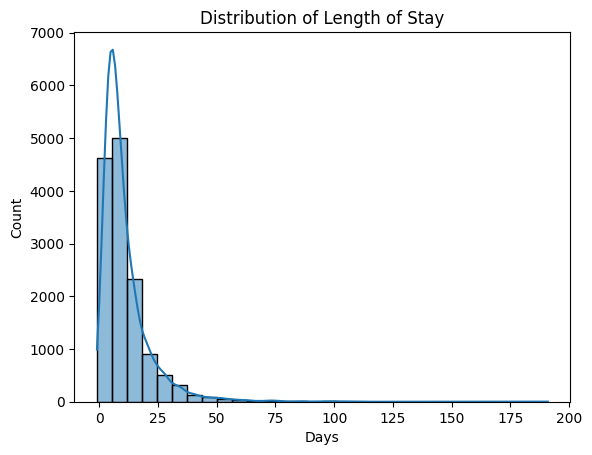

In [74]:
hf_admissions_full['length_of_stay_days'] = (hf_admissions_full['dischtime'] - hf_admissions_full['admittime']).dt.days

# Visualize LOS
sns.histplot(hf_admissions_full['length_of_stay_days'], bins=30, kde=True)
plt.title("Distribution of Length of Stay")
plt.xlabel("Days")
plt.show()

In [75]:
# for col in numerical_cols:
#     plt.figure(figsize=(10, 4))
#     sns.boxplot(x='readmit_30_days', y=col, data=hf_admissions_full)
#     plt.title(f"{col} vs Readmission")
#     plt.show()

In [76]:
# for col in categorical_cols:
#     plt.figure(figsize=(10, 4))
#     sns.countplot(data=hf_admissions_full, x=col, hue='readmit_30_days')
#     plt.title(f"{col} vs Readmission")
#     plt.xticks(rotation=45)
#     plt.show()

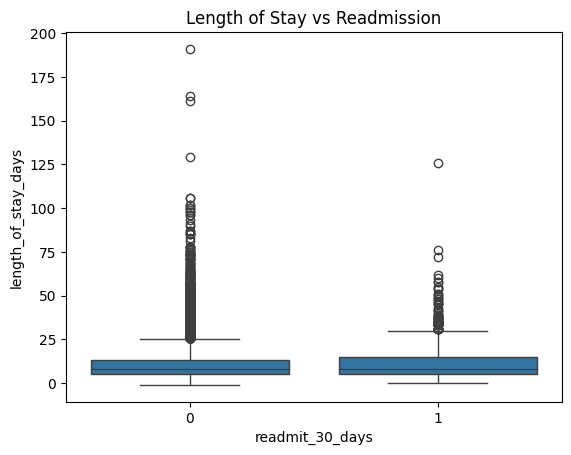

In [77]:
sns.boxplot(data=hf_admissions_full, x='readmit_30_days', y='length_of_stay_days')
plt.title("Length of Stay vs Readmission")
plt.show()

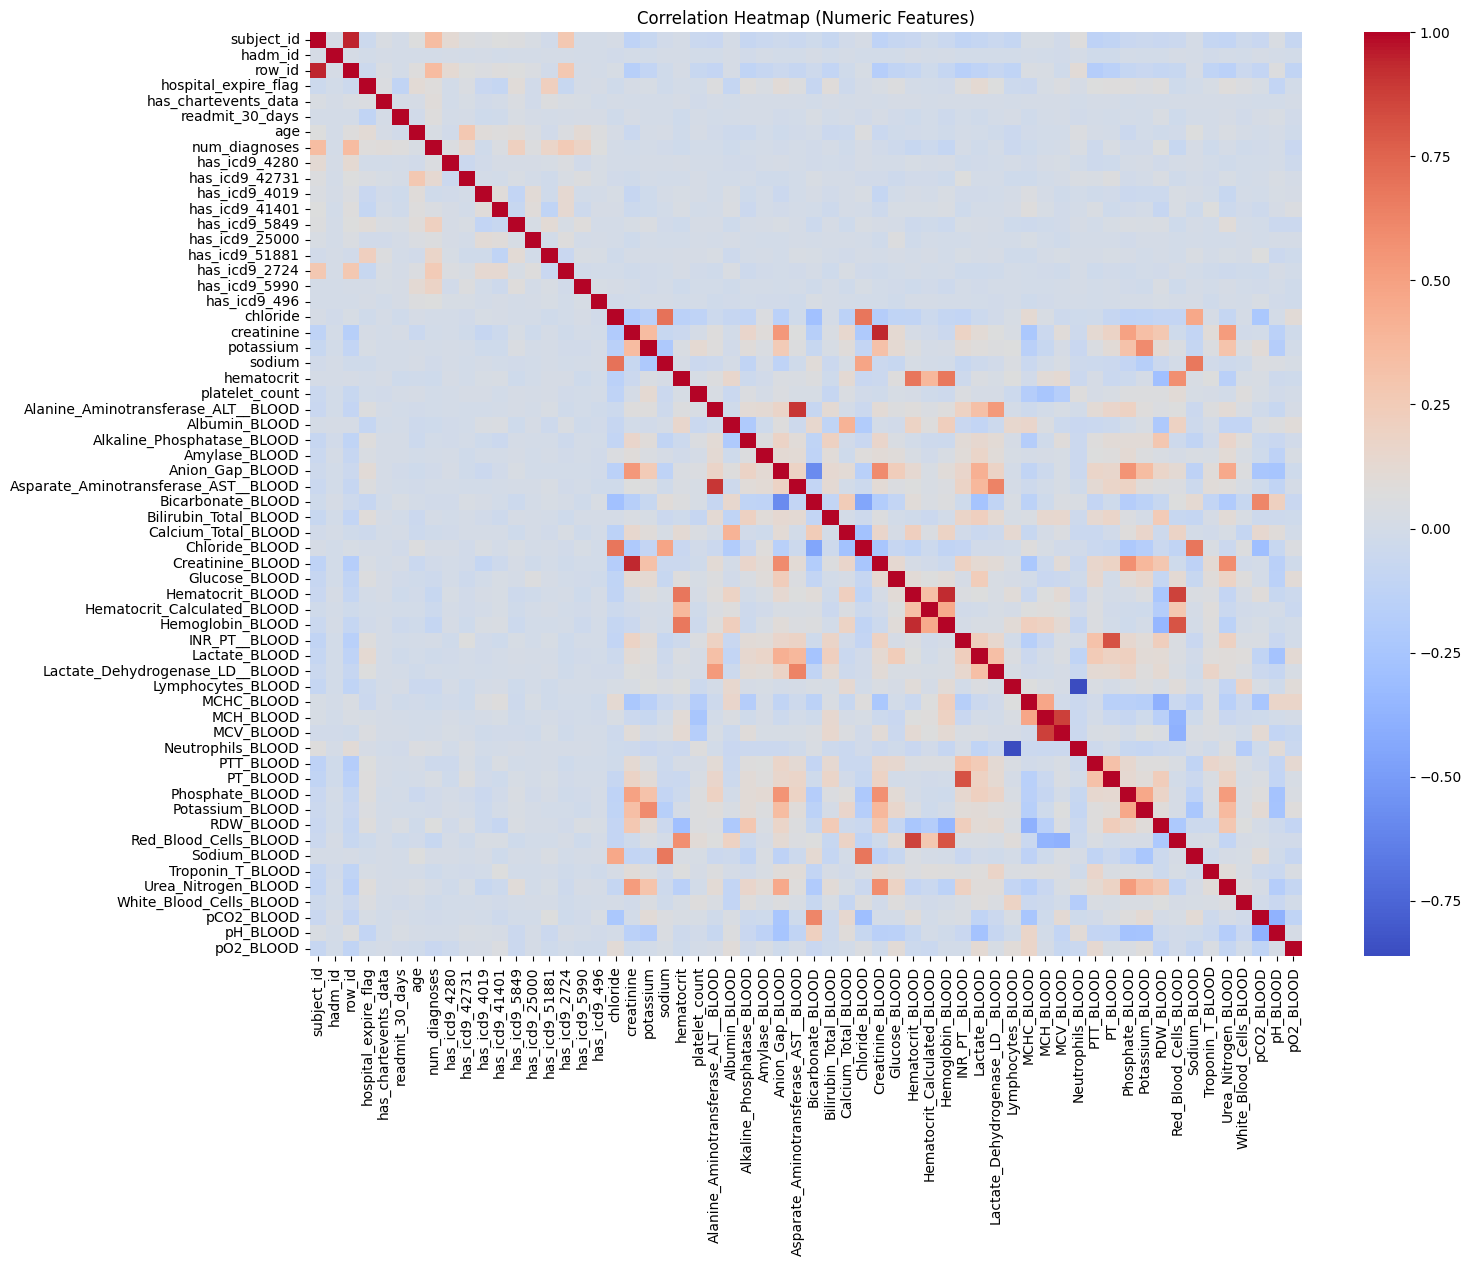

In [78]:
plt.figure(figsize=(16, 12))
sns.heatmap(hf_admissions_full[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# **FEATURE SELECTION**


In [79]:
drop_cols = [
    'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
    'edregtime', 'edouttime', 'next_admittime', 'diagnosis',
    'language', 'religion',
    'days_to_next_admit'
]
hf_model_data = hf_admissions_full.drop(columns=[col for col in drop_cols if col in hf_admissions_full.columns])


In [80]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = hf_model_data.select_dtypes(include='object').columns

le = LabelEncoder()
for col in categorical_cols:
    hf_model_data[col] = le.fit_transform(hf_model_data[col].astype(str))

In [81]:
hf_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14040 entries, 0 to 14039
Data columns (total 68 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   row_id                                14040 non-null  int64         
 1   admission_type                        14040 non-null  int64         
 2   admission_location                    14040 non-null  int64         
 3   discharge_location                    14040 non-null  int64         
 4   insurance                             14040 non-null  int64         
 5   marital_status                        14040 non-null  int64         
 6   ethnicity                             14040 non-null  int64         
 7   hospital_expire_flag                  14040 non-null  int64         
 8   has_chartevents_data                  14040 non-null  int64         
 9   current_dischtime                     14040 non-null  datetime64[ns]
 10

In [82]:
hf_model_data.drop(columns=['row_id',], inplace=True)

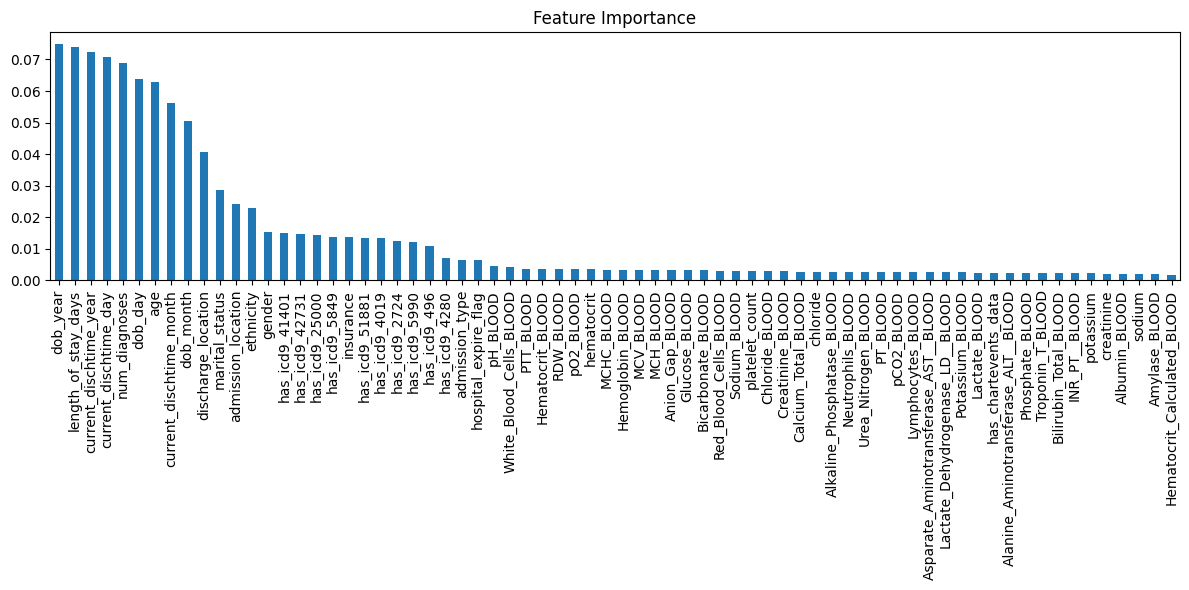

In [84]:
from sklearn.ensemble import RandomForestClassifier

X = hf_model_data.drop(columns=['readmit_30_days'])
y = hf_model_data['readmit_30_days']

for col in X.select_dtypes(include=['datetime64[ns]']).columns:
    X[col + '_year'] = X[col].dt.year
    X[col + '_month'] = X[col].dt.month
    X[col + '_day'] = X[col].dt.day
    X.drop(columns=col, inplace=True)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Feature Importance")
plt.tight_layout()
plt.show()

In [85]:
# Sort feature importances
sorted_importances = importances.sort_values(ascending=False)

# View top N 20
print(sorted_importances.head(20))

# Set threshold
threshold = 0.01

# Filter features above threshold
selected_features = sorted_importances[sorted_importances > threshold].index.tolist()

# Reduce your data
X_selected = X[selected_features]

dob_year                   0.074858
length_of_stay_days        0.073805
current_dischtime_year     0.072362
current_dischtime_day      0.070784
num_diagnoses              0.068772
dob_day                    0.063853
age                        0.062965
current_dischtime_month    0.056241
dob_month                  0.050493
discharge_location         0.040655
marital_status             0.028760
admission_location         0.024077
ethnicity                  0.022817
gender                     0.015203
has_icd9_41401             0.015128
has_icd9_42731             0.014635
has_icd9_25000             0.014226
has_icd9_5849              0.013870
insurance                  0.013851
has_icd9_51881             0.013393
dtype: float64


In [86]:
print(f"Total features before: {X.shape[1]}")
print(f"Total features after selection: {len(selected_features)}")

Total features before: 70
Total features after selection: 24


In [88]:
%pip install imbalanced-learn

In [89]:
%pip install --upgrade scikit-learn

In [93]:
y.value_counts()

,count
readmit_30_days,
0,13072
1,968


# **CREATING CSV FILE TO USE FOR MODEL IMPLEMENTATION**

In [94]:
hf_model_data.to_csv('hf_model_data.csv', index=False)